# Objective: Customer Revenue Prediction

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.
This notebook will analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset from Kaggle competition ['Google Analytics Customer Revenue Prediction'](https://www.kaggle.com/c/ga-customer-revenue-prediction) to predict revenue per customer. 

### About the dataset:

* Train data sample size : 903653 
* Test data sample size : 804684 

Each row in the dataset is one visit to the store. Targeted outputs are prediction of the natural log of the sum of all transactions per user.
The data fields in the given files include > 50 columns, for the following key areas:

* fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

In [1]:
from IPython.display import Image
import pandas as pd

# Data Analysis & Feature Engineering

## 1. Target Dependent Variable Exploration
* Number of unique users: 731571 
* Number of customers that contribute to revenue: 10223, ~ 1.4%

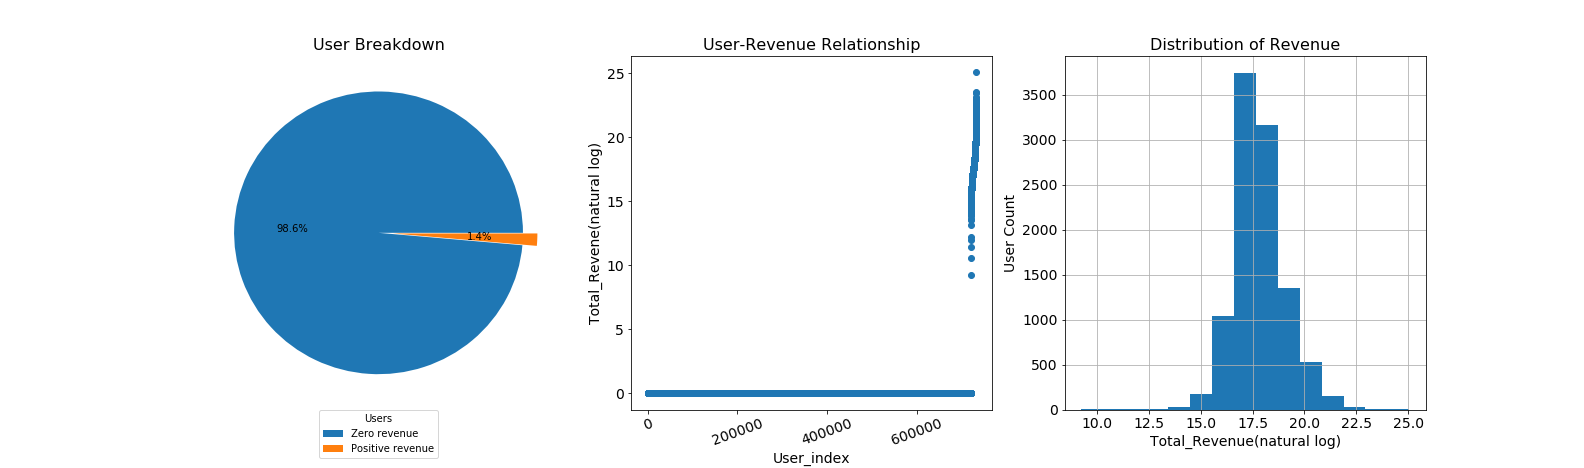

In [2]:
Image('./Output/1_User-Revenue Overview.png')

## 2. Time-Series User Acitivity Analysis
* Peak period of mid- to late-Aug 2016 in positive transactions, while no signicant increase in total count activity was observed (can potentially be correlated to July 2016 data that is not available)
* Nov 2016, high user activity but low positive transactions; early Dec, positive transactions start to go up even though total count of user activity decrease (customer expection during BlackFriday, late promotion event?)
* ~ Valentine's day 2017, high percentage of positive transactions; but total count of user activity on the low range, there is a spike on 1/24
* April 26,2017 spike in total user acvitivity may be related to the follow-up increase of positive transactions

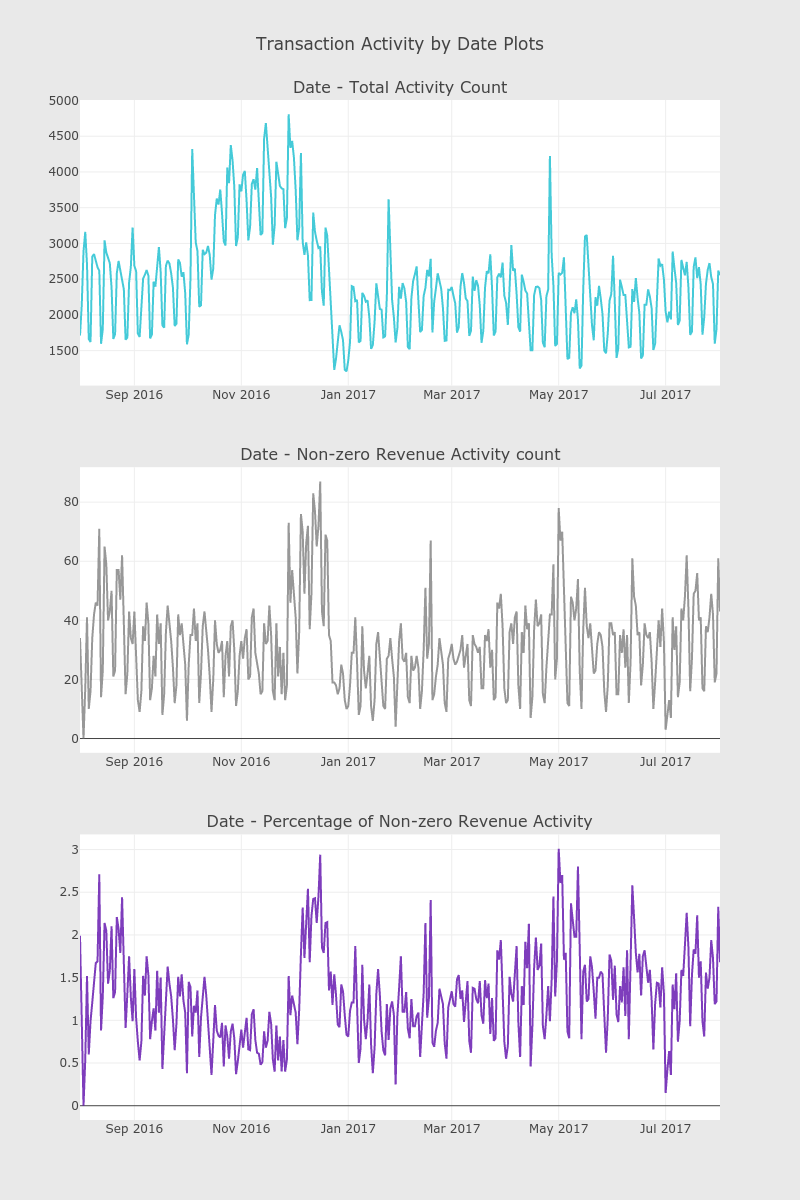

In [3]:
Image('./Output/6_transaction activity by date summary.png')

## 3. User Habit Analysis - Day & Time

* Both user activity and positive transactions have periodic patten: more activites during some days during a week

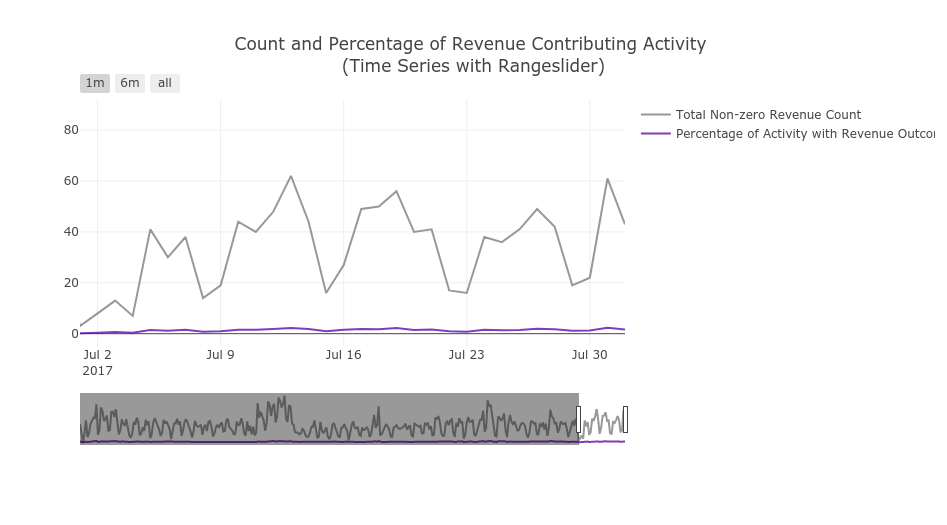

In [4]:
Image( './Output/4_count of revenue activity_1month.png' )

* Sunday has the highest amount of transaction completion, while Friday has the lowest number of transaction
* Customers prefer to browse and place orders during the period of Sunday through Thursday

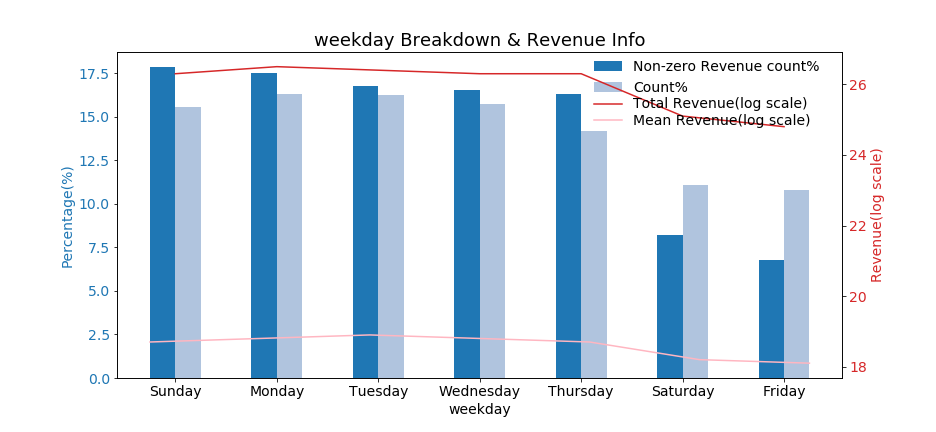

In [5]:
Image('./Output/7-weekday Breakdown & Revenue.png')

* Most customers prefer to place orders during the daytime, the highest numbers of transactions are completed between 10am-2pm, with peak at 10am-noon.

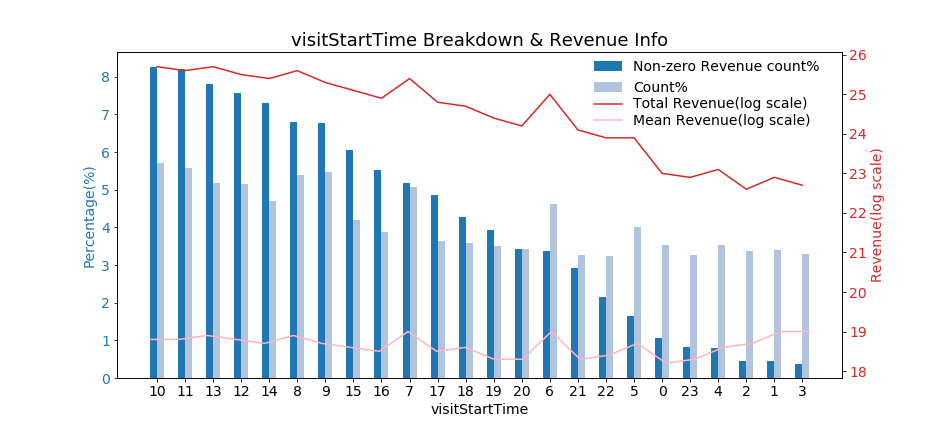

In [6]:
Image('./Output/8-visitStartTime Breakdown & Revenue.png')

## 4. User Habit Analysis - Source Channel
* Referral resulted in the most of positive revnue transaction counts and highest total revenue, followed by Organic Seach and Direct
* Organic Search and Social consitute over 60% of total user activity count
* Display has the highest mean revenue, followed by Direct

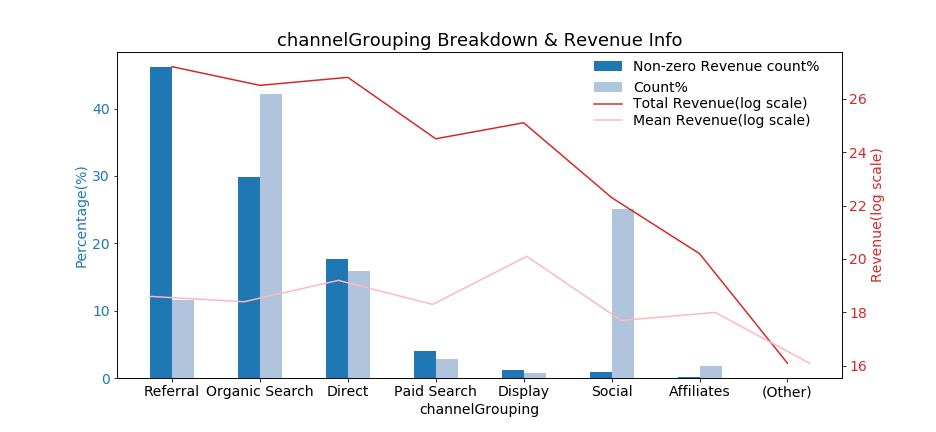

In [7]:
Image('./Output/9-channelGrouping Breakdown & Revenue.png')

## 5. User Habit Analysis - Device and Platform
* Over 70% users used computers to browse products; over 90% customers used computers to place orders

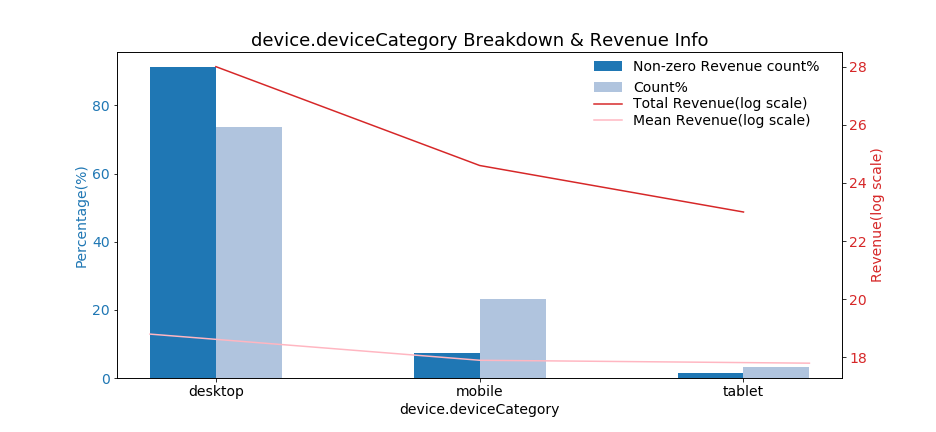

In [8]:
Image('./Output/13-device.deviceCategory Breakdown & Revenue.png')

* Web browser: Chrome has the highest transactions and total revenues; interestingly, firefox users contributed to the highest mean revenue

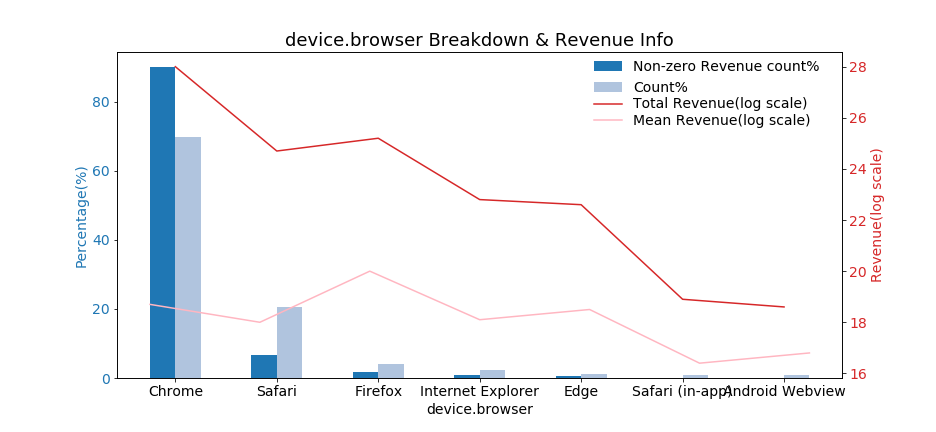

In [9]:
Image('./Output/12-device.browser Breakdown & Revenue.png')

* Macintosh and Windows users are the two groups contributing to the highest transactions and total revenue
* Chrome OS and ANdroid users have relatively high mean revenue within the desktop and mobile user groups, respectively

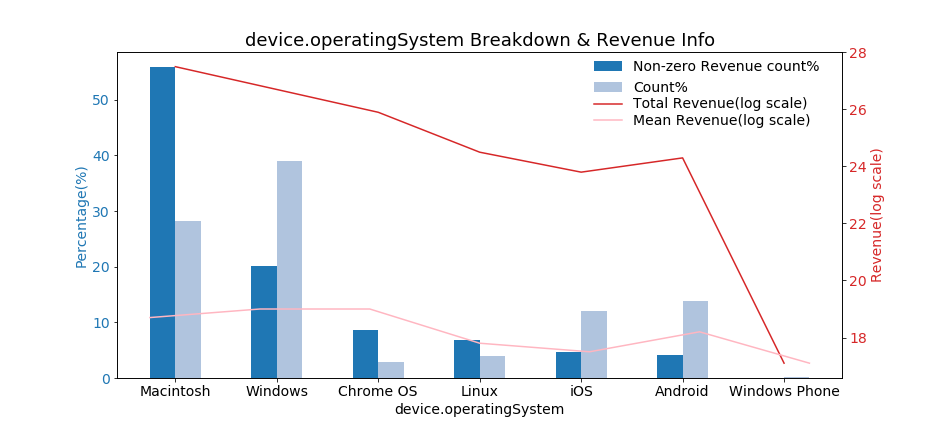

In [10]:
Image('./Output/14-device.operatingSystem Breakdown & Revenue.png')

## 6. User Geography Analysis
* North America, mostly United States, contributes to the revenue the most, followed by Canada and Venezuela
* Africa has relatively high revenue, even though not as many visit counts as other continents; Nigeria and Kenya have the highest mean revenue

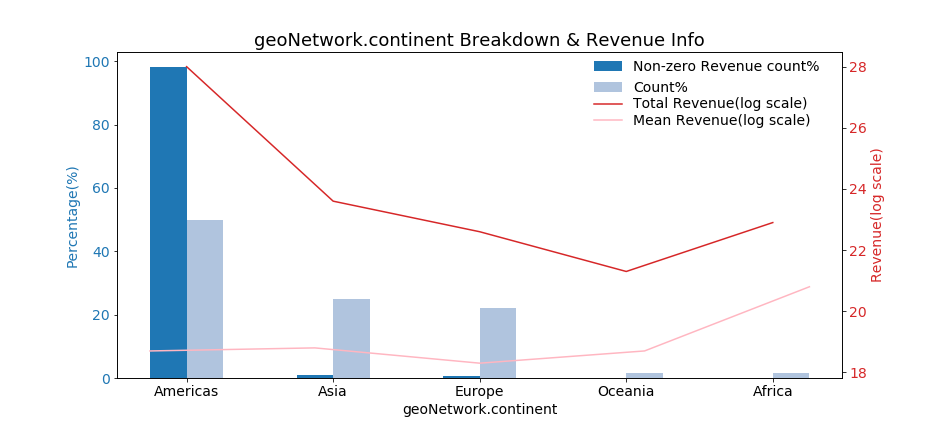

In [11]:
Image('./Output/15-geoNetwork.continent Breakdown & Revenue.png')

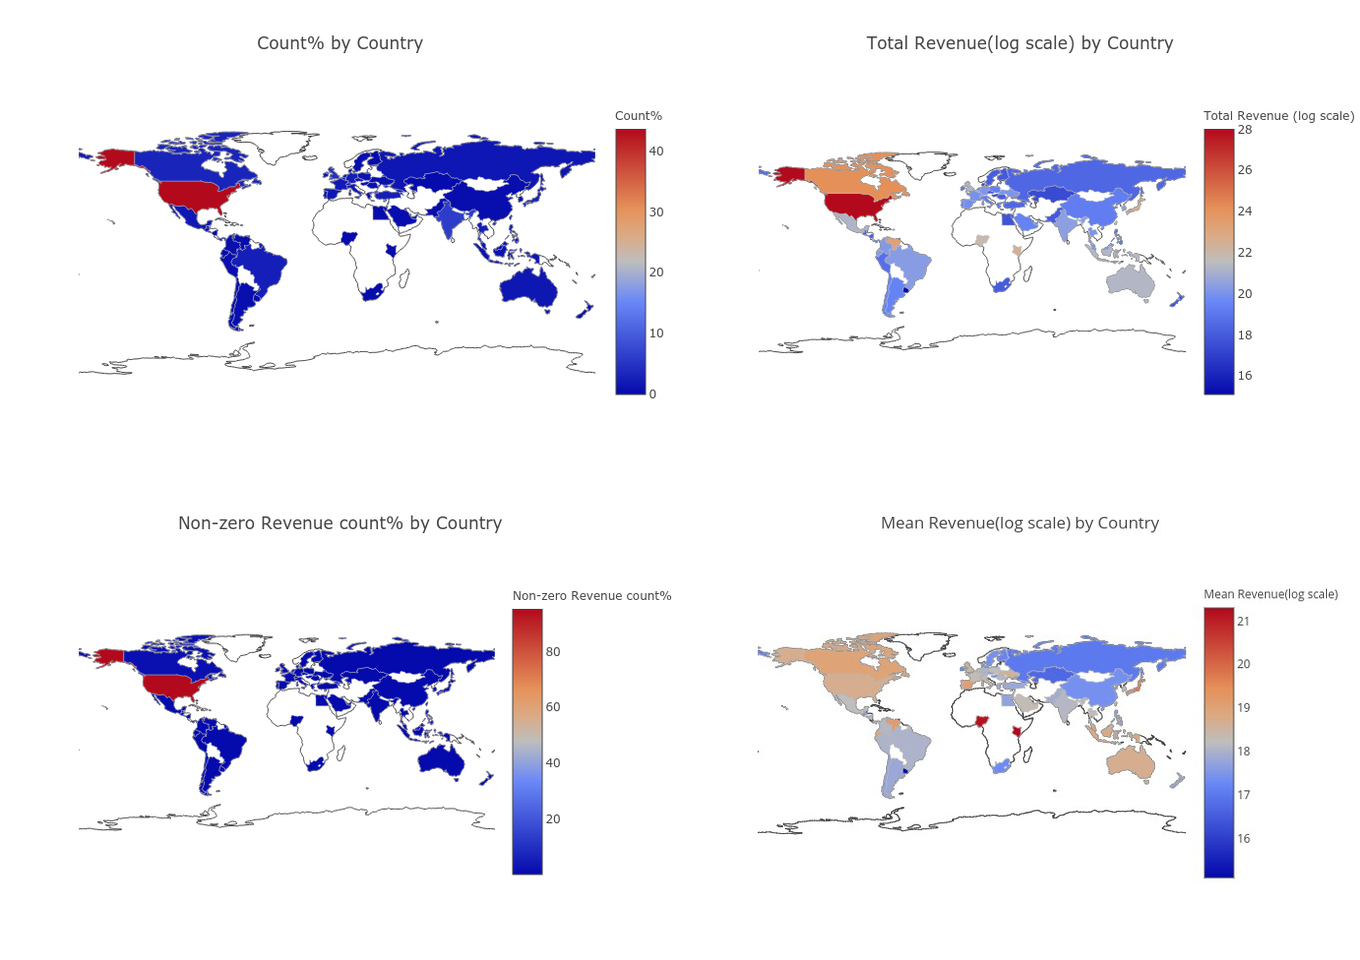

In [12]:
Image('./Output/20-GeoSummary.png')

## 7. User Network Analysis
* Comcastbusiness.net and comcast.net users contributed to the most revenue among the network domains; correlates to previous findings that most customers use computers to browse products and place orders
* Verizon is on the top5 revenue sources, but not AT&T and T-mobile

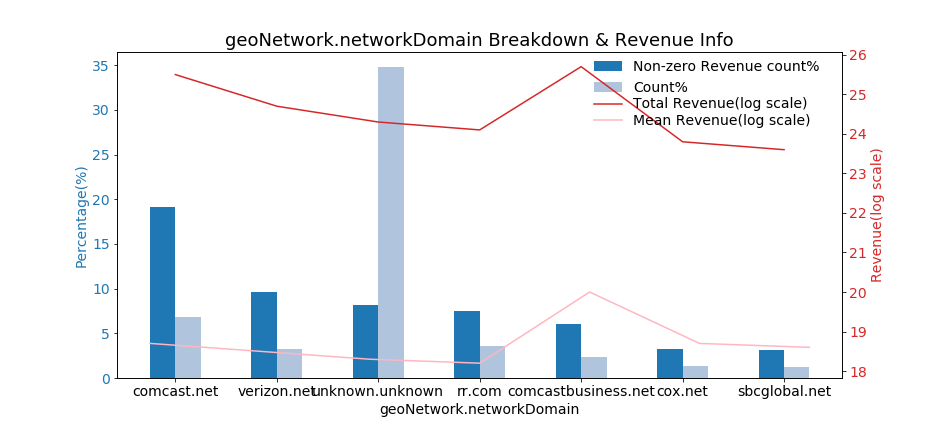

In [13]:
Image('./Output/17-geoNetwork.networkDomain Breakdown & Revenue.png')

## 8. User page visit
* Most users have less than 100 hits and pageviews
* Users with less than 40 hits and pageviews contribute to the most revenues

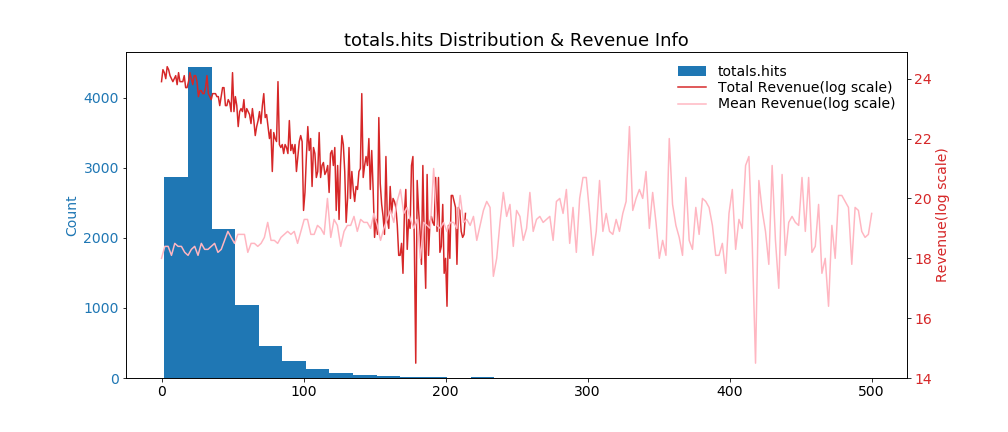

In [14]:
Image('./Output/23-totals.hits Distribution & Revenue.png')

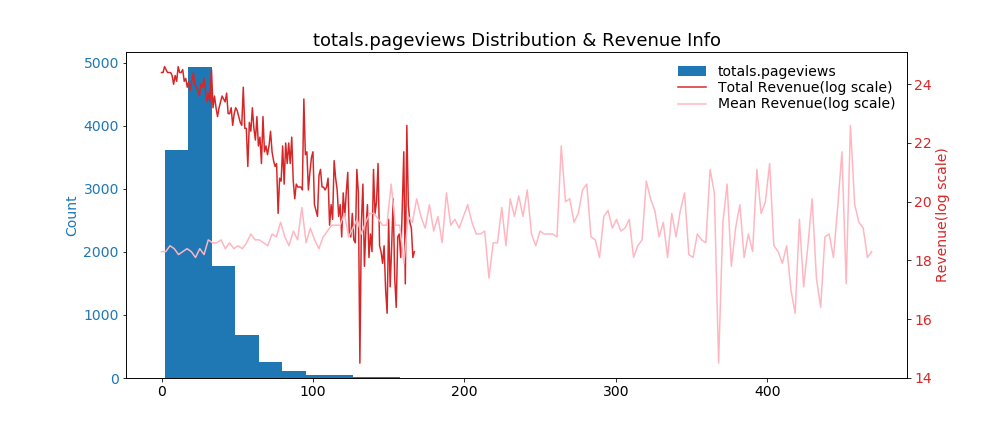

In [15]:
Image('./Output/24-totals.pageviews Distribution & Revenue.png')

# Building Model for Revenue Prediction

## Correlation Matrix for Feature Selection
Drop features:
* 'trafficSource.medium', 'trafficSource.source' strongly correlate with 'channelGrouping'
* 'device.isMobile' strongly correlates with 'device.deviceCategory'
* 'totals.hits' strongly correlates with 'totals.pageviews'

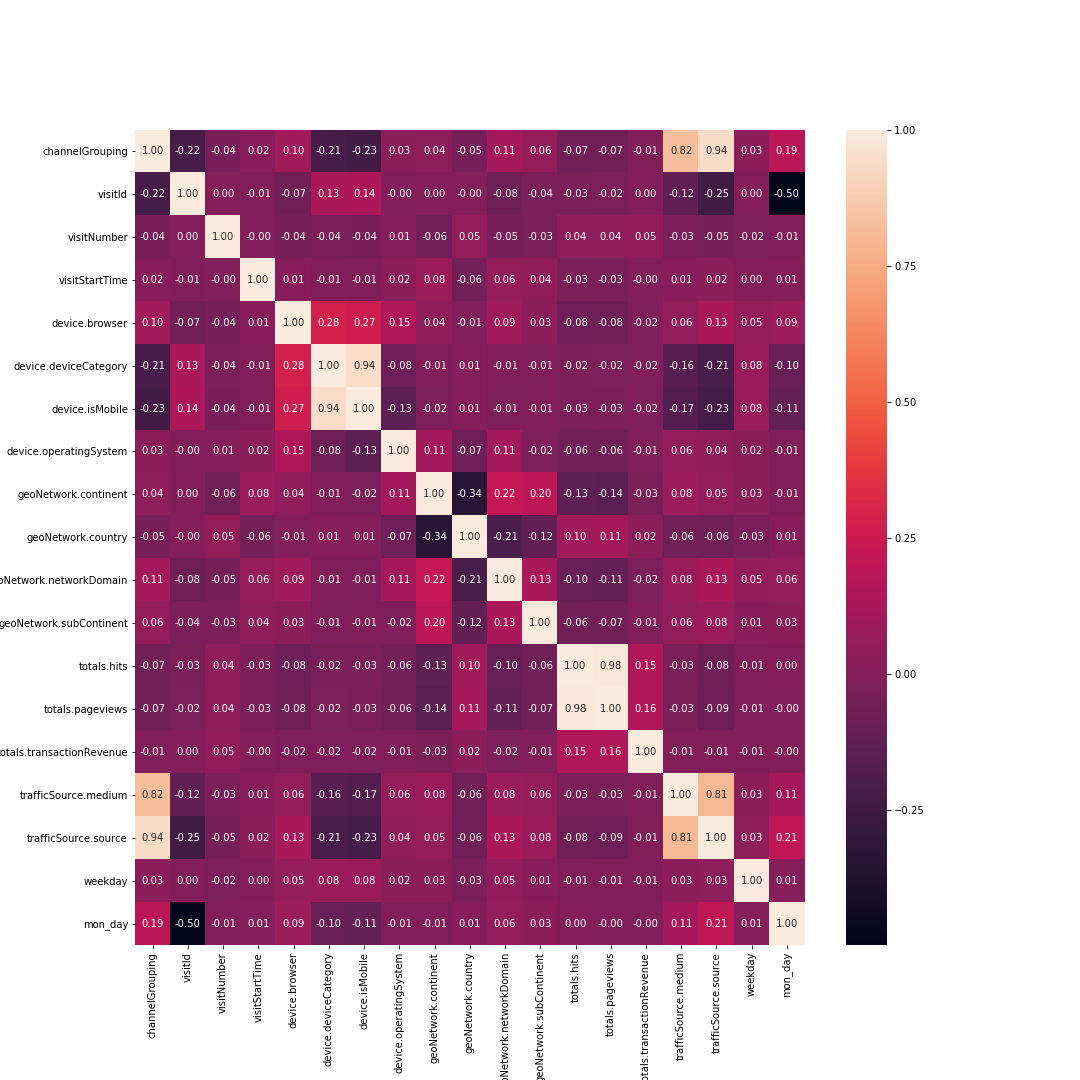

In [16]:
Image('./Output/Pearson correlation.png')

* 13 features will be used for model training, including: 
'channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.pageviews', 'weekday', 'mon_day'
* 7 Types of regression model was trained and evaluated based on Root Mean Square Error (RMSE)
 * Gradient Boosting model has the lowest RMSE
 * Light Gradient Boosting model will be used for further optimization

In [17]:
Mod_Summary = pd.read_csv('./Output/Baseline model selection.csv')
Mod_Summary

,Unnamed: 0,Model Type,Training Score,Validation Score,RMSE
0,0,LinearRegression,0.162140,0.172594,1.83698
1,1,Lasso,0.009378,0.010082,2.00930
2,2,Ridge,0.162140,0.172594,1.83698
3,3,KNeighborsRegressor,0.397141,0.108303,1.90701
4,4,DecisionTreeRegressor,0.998716,-0.401312,2.39063
5,5,RandomForestRegressor,0.855042,0.206139,1.79935
6,6,GradientBoostingRegressor,0.301720,0.313311,1.67349


## Model Parameter Tuning 
* ~ 20 Combinations of params were tried to minimize rmse on the validation set to 1.60676,key params include:  
    "num_leaves" : 31,
    "max_depth" : 7,
    "min_data_in_leaf": 20,
    "learning_rate" : 0.07,
    "bagging_fraction" : 1,
    "feature_fraction" : 1
    
## Feature Importance Metric

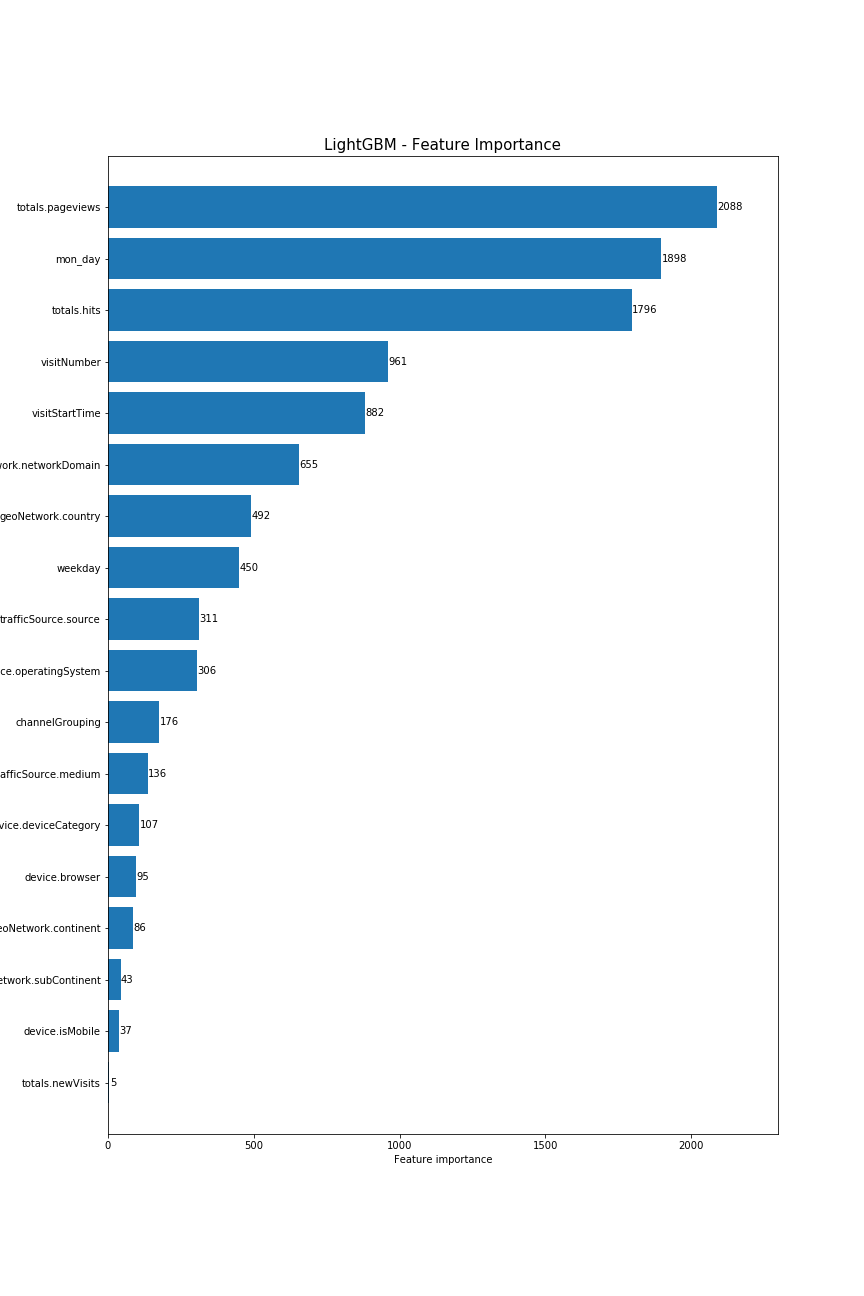

In [18]:
Image('./Output/33-Feature Importance.png')